In [1]:
from sklearn.metrics import median_absolute_error
import matplotlib.pyplot as plt
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from matplotlib.offsetbox import AnnotationBbox, TextArea
from mapie.regression import MapieQuantileRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint, uniform
from sklearn.ensemble import HistGradientBoostingRegressor
import seaborn as sns
from treeffuser import Treeffuser
import numpy as np
from data import load_amp, load_uke
import pandas as pd
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted_,
    y_pred_sorted_,
    lower_bound_,
    upper_bound,
    coverage,
    width,
):
    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval",
        alpha=0.5
    )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval",
        alpha=0.5
    )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("Observed PDQ")
    axs.set_ylabel("Predicted PDQ")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, 3)}\n"
            + f"Interval width: {np.round(width, 3)}\n"
            + f"MAE: {np.round(median_absolute_error(y_true=y_test_sorted_, y_pred=y_pred_sorted_), 3)}"
        ),
        xy=(np.min(y_test_sorted_) + np.max(y_test_sorted_) / 2, np.max(y_pred_sorted_+error)*0.95),
    )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title)


In [3]:
PDQ_COLUMNS = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]
COVARIATES = ["Time since diagnosis", "Age", "Sex"]
EXTRA_COVARIATES = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "MoCA"]
SEED = 42


def cast_to_float(data):
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors="coerce")
    return data


def preprocess_covariates(data):
    data = data.copy()
    data["Sex"] = data["Sex"].map({"Male": 0.0, "Female": 1.0})
    data = cast_to_float(data)
    return data


def parse_data(y, covariates):
    data = pd.concat(
        (y[["Participant", "Study", "Visit ID", *PDQ_COLUMNS,
         *EXTRA_COVARIATES]], covariates[COVARIATES]), axis=1
    ).dropna(thresh=4 + len(COVARIATES) + len(EXTRA_COVARIATES))
    data["Visit ID"] = data["Visit ID"].str[1:].astype(int)
    data = data[data["Study"] != "HBS"]

    X = []
    y = []
    extra_data = []

    for _, data in data.sort_values(
        ["Participant", "Visit ID"], ascending=True
    ).groupby(["Participant"]):
        for iloc, (_, row) in enumerate(data.iterrows()):
            if iloc > 0:
                previous_row = data.iloc[iloc - 1]
                previous_row = previous_row[PDQ_COLUMNS].to_list() + [
                    (row["Visit ID"] - previous_row["Visit ID"]) / 12.0
                ]
            else:
                previous_row = [np.nan] * (len(PDQ_COLUMNS) + 1)

            X.append(
                previous_row + row[COVARIATES].to_list() + row[EXTRA_COVARIATES].to_list())
            y.append(row[PDQ_COLUMNS])
            extra_data.append([row["Study"]])

    return preprocess_covariates(
        pd.DataFrame(X, columns=PDQ_COLUMNS +
                     ["Time since last visit"] + COVARIATES + EXTRA_COVARIATES)
    ), cast_to_float(pd.DataFrame(y, columns=PDQ_COLUMNS).reset_index(drop=True)), pd.DataFrame(extra_data, columns=["Study"])


# Load the AMP data
X_amp, covariates_amp = load_amp(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp_all.csv",
    sample_one_measurement_per_subject=False,
)
X_amp, y_amp, extra_data_amp = parse_data(X_amp, covariates_amp)

# Load the UKE data
X_uke, covariates_uke, extra_data_uke, y_uke = load_uke(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv",
    PDQ_COLUMNS + EXTRA_COVARIATES,
)

X_uke = pd.concat(
    (
        X_uke,
        extra_data_uke[["Time since last test"]].rename(
            columns={"Time since last test": "Time since last visit"}
        ),
        covariates_uke[COVARIATES],
    ),
    axis=1,
)
full_measurements_uke = pd.isna(X_uke).sum(axis=1) < 4
X_uke = preprocess_covariates(X_uke)[full_measurements_uke]
covariates_uke = covariates_uke[full_measurements_uke]
extra_data_uke = extra_data_uke[full_measurements_uke]
y_uke = y_uke[full_measurements_uke]

# Select only one participant
included_predictions = (pd.isna(X_amp[PDQ_COLUMNS]).sum(
    axis=1) == len(PDQ_COLUMNS)) & (extra_data_amp["Study"] != "HBS")
y_amp = y_amp[included_predictions].mean(axis=1).reset_index(drop=True)
X_amp = X_amp[COVARIATES +
              EXTRA_COVARIATES][included_predictions].reset_index(drop=True)
extra_data_amp = extra_data_amp[included_predictions].reset_index(drop=True)

INDICES_TEST_SET = extra_data_amp["Study"] == "Sure"
X_amp_train = X_amp[~INDICES_TEST_SET]
y_amp_train = y_amp[~INDICES_TEST_SET]
X_amp_test = X_amp[INDICES_TEST_SET]
y_amp_test = y_amp[INDICES_TEST_SET]

## Define an tune the base regressor

In [4]:
estimator = HistGradientBoostingRegressor(
    random_state=SEED, loss="quantile", quantile=0.5)

params_distributions = dict(
    max_leaf_nodes=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    max_iter=randint(low=50, high=100),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=50,
    cv=KFold(n_splits=10, shuffle=True, random_state=SEED),
    random_state=SEED
)
optim_model.fit(X_amp_train, y_amp_train)
estimator = optim_model.best_estimator_

## 1. Predict only the median

Median absolute error:  2.626200206118016


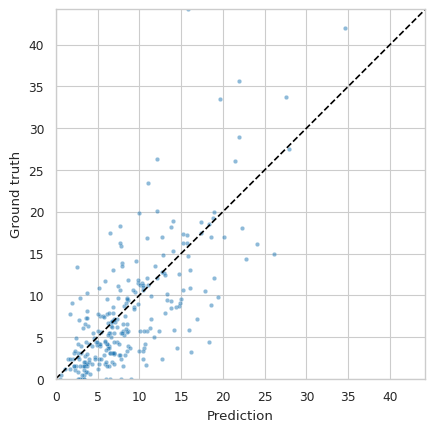

In [5]:
prediction_baseline = pd.DataFrame({
    "Prediction": estimator.predict(X_amp_test),
    "Ground truth": y_amp_test
})

with sns.axes_style("whitegrid"):
    sns.set_context("paper")
    ax = sns.scatterplot(prediction_baseline, x="Prediction",
                         y="Ground truth", alpha=0.5, s=10)
    ax.set_aspect("equal")
    ax.set_xlim(0, max(prediction_baseline.max()))
    ax.set_ylim(0, max(prediction_baseline.max()))
    ax.plot([0, max(prediction_baseline.max())], [
            0, max(prediction_baseline.max())], color="black", linestyle="--")
    
print("Median absolute error: ", median_absolute_error(prediction_baseline["Ground truth"], prediction_baseline["Prediction"]))

## 2. Predict with quantile regressor

INFO:root:The predictions are ill-sorted.


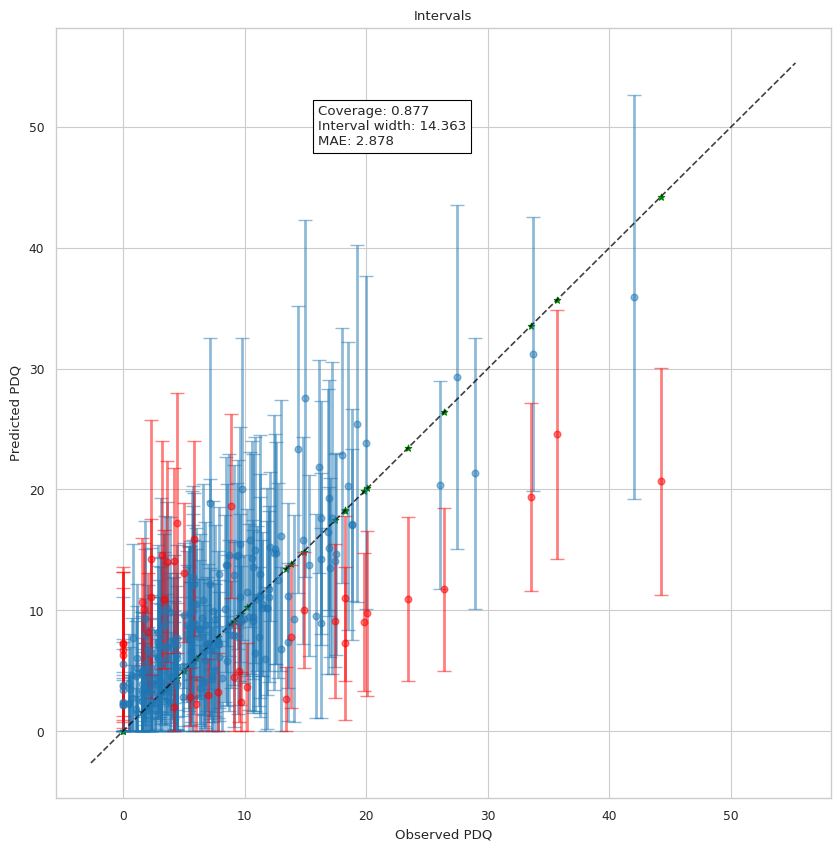

In [9]:
mapie = MapieQuantileRegressor(
    estimator, method="quantile", cv="split", alpha=0.2)
mapie.fit(
    X_amp_train,
    y_amp_train,
    calib_size=0.3,
    random_state=SEED
)

y_quantile_pred, y_quantile_pis = mapie.predict(X_amp_test)
y_quantile_pred = np.clip(y_quantile_pred, 0, 100)
y_quantile_pis = np.clip(y_quantile_pis, 0, 100)

(
    y_amp_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound
) = sort_y_values(y_amp_test, y_quantile_pred, y_quantile_pis)
coverage = regression_coverage_score(
    y_amp_test,
    y_quantile_pis[:, 0, 0],
    y_quantile_pis[:, 1, 0]
)
width = regression_mean_width_score(
    y_quantile_pis[:, 0, 0],
    y_quantile_pis[:, 1, 0]
)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_prediction_intervals(
        "Intervals",
        ax,
        y_amp_test_sorted,
        y_pred_sorted,
        lower_bound,
        upper_bound,
        coverage,
        width
    )

## 3. Predict with Treeffuser

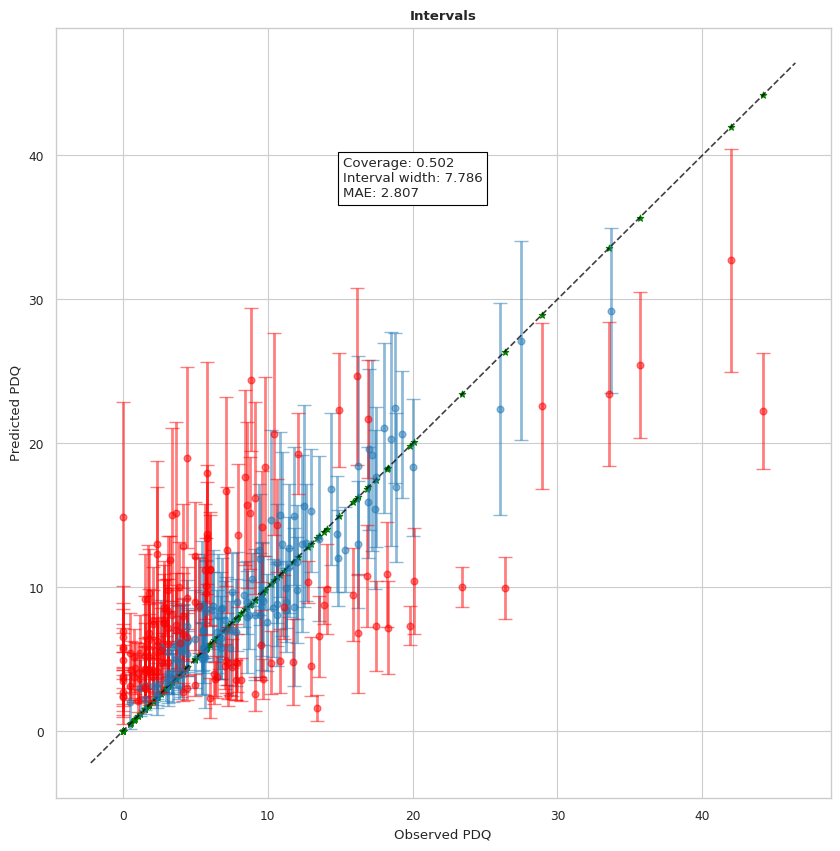

In [7]:
generative_model = Treeffuser(seed=SEED)
generative_model.fit(X_amp_train.to_numpy().astype(
    np.float32), y_amp_train.to_numpy().astype(np.float32))
y_amp_sampled = generative_model.sample(
    X_amp_test.to_numpy().astype(np.float32), 500, seed=SEED)
y_amp_sampled = np.clip(y_amp_sampled, 0, 100)

y_amp_sampled_quantiles = np.quantile(y_amp_sampled, [0.1, 0.5, 0.9], axis=0)
y_amp_sampled_pi = np.swapaxes(y_amp_sampled_quantiles[(0, 2), :], 0, 1)[
    :, :, np.newaxis]

(
    y_amp_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound
) = sort_y_values(y_amp_test, y_amp_sampled_quantiles[1, :], y_amp_sampled_pi)

coverage = regression_coverage_score(
    y_amp_test,
    y_amp_sampled_pi[:, 0, 0],
    y_amp_sampled_pi[:, 1, 0]
)
width = regression_mean_width_score(
    y_amp_sampled_pi[:, 0, 0],
    y_amp_sampled_pi[:, 1, 0]
)

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_prediction_intervals(
        "Intervals",
        ax,
        y_amp_test_sorted,
        y_pred_sorted,
        lower_bound,
        upper_bound,
        coverage,
        width
    )